In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch)

$x$ wird gesucht.

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.dot(A, x)

$A$ ist invertierbar:

In [5]:
if A.shape[0] == A.shape[1]:
    print(np.linalg.inv(A))

[[ 0.58611217  0.22754722  0.22079958 ... -0.35934623  0.66178901
   0.19085717]
 [-0.86053578  0.35823913 -0.05086583 ... -0.28753986  0.01246512
  -1.48921599]
 [ 0.26764428 -0.13717687 -0.92694754 ...  0.09591585 -1.22390556
   2.1684163 ]
 ...
 [ 0.66359634 -0.39434052  0.53305901 ...  0.12365094  0.66198343
   0.04954313]
 [-0.06110287  0.01871632 -0.28590078 ...  0.03731371 -0.48258655
   0.91014539]
 [-1.43651032  0.47662975 -0.21419412 ... -0.01676364  0.36827009
  -2.7539353 ]]


Verlustfunktion: mittlerer quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2$

In [6]:
from sklearn.metrics import mean_squared_error

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-\frac{2}{n}(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) / y_true.shape[0] * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

2.2212952243689785

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 1000
randomization = False

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.dot(A, param_mean)))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, np.dot(A, param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

Mit Randomization: Loss schwankt ungleichmäßig.

Ohne Randomization: Loss bleibt gleich ?!

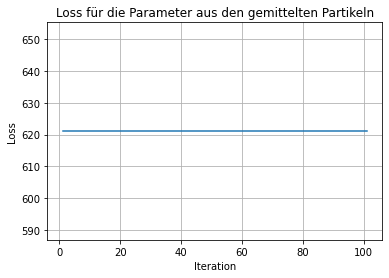

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

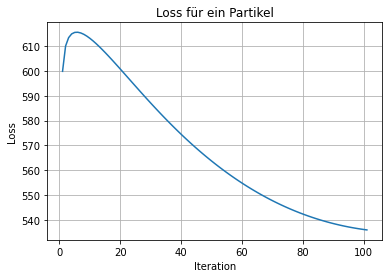

In [24]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

## EnKF wie für inverse Probleme

#### Ergebnisse:
- Im besten Fall konvergiert der Loss gegen den Loss, wenn der Mittelwert von $y$ als prediction verwendet wird. 
    
    **Korrektur**: mit mehr Partikeln wird es besser als der Loss für den Mittelwert!
- Noise:
    - Mit $\Gamma$ im Update: sehr schlechte Ergebnisse (Loss explodiert für Noise aus $\mathscr{N}(0, 0.1)$).
    - Ohne $\Gamma$ im Update: wieder Konvergenz gegen den Loss des Mittelwerts.
- Batch-Size: 
    - Verhalten bleibt
    - Code schneller

In [25]:
noise = False
y = np.dot(A, x)
stddev_noise = np.ones(shape = y.shape)
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [26]:
batch = True
if batch:
    epochs = 10
    batch_size = int(np.floor(y.shape[0] / 10))         
else:
    epochs = 100
    batch_size = y.shape[0]

In [27]:
particles = 2000
epochs = 100
batch_size = 10

In [28]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [29]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [30]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [31]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [32]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.dot(A, param_mean)))

In [33]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

In [34]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    if noise:
        gamma_batches = [gamma[int(batch_indices[i]):int(batch_indices[i+1]),int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    
    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
            loss_dict["particle_{}".format(i+1)] = mean_squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            if noise:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma_batches[b])), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])
            else:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(mean_squared_error(y, np.dot(A, param_mean)))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

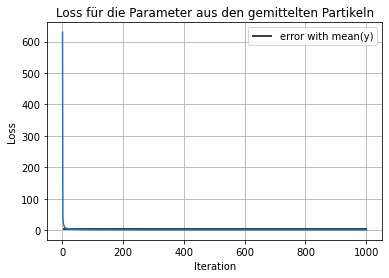

In [35]:
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 1, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

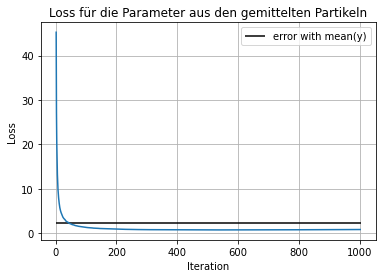

In [36]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

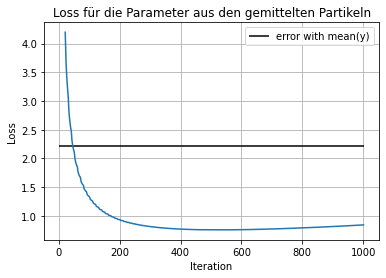

In [37]:
# ab der 20. Iteration (bei Batch-Size = 10 also nach Abschluss der 2. Epoche)
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))[20:]+1, loss_evolution[20:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

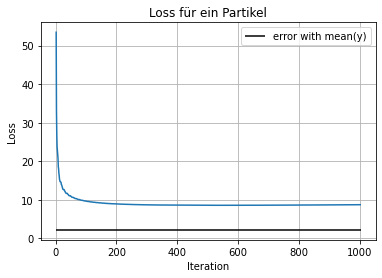

In [38]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))[1:]+1, loss_evolution_single_dict["particle_1"][1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

In [39]:
np.dot(A, param_mean)

array([23.14957807, 25.64008082, 25.14308701, 24.42720516, 24.18133391,
       27.61541194, 20.61661579, 24.50960842, 22.4635719 , 23.38053944,
       27.56896808, 29.3076552 , 24.37540356, 26.26880283, 25.80720239,
       24.47737816, 24.83358531, 24.04504604, 26.17687915, 23.28464681,
       24.66942655, 26.48006052, 24.02556301, 24.38452835, 24.79219297,
       25.67858538, 23.61025146, 25.54218979, 24.73258443, 27.75233547,
       23.74516969, 23.71414895, 23.54509787, 25.13515576, 26.72050131,
       24.1293111 , 24.44803474, 24.93255333, 25.21168756, 23.15243661,
       25.43292855, 23.87947833, 23.27733054, 25.37671505, 24.41123136,
       25.34226335, 26.5883092 , 23.33462513, 24.10327277, 26.59225713,
       23.89409993, 25.82783374, 26.24575914, 25.44187777, 23.865882  ,
       24.01269028, 24.0758197 , 26.61868306, 24.87778485, 24.16846898,
       24.88989012, 23.31281508, 25.35986033, 24.09703883, 26.159383  ,
       24.17958289, 24.97668832, 25.07849944, 25.24585083, 24.79

In [40]:
y

array([24.93864062, 24.09099148, 26.25305628, 24.05640439, 24.64454397,
       28.16979309, 21.67023114, 26.97393195, 22.24643928, 23.35476629,
       27.45352245, 28.53033815, 24.320793  , 27.63236822, 26.14936327,
       24.90531817, 26.07236955, 24.33898551, 26.91819902, 24.20534451,
       25.79499432, 25.88499083, 24.38543291, 25.83176522, 26.83586517,
       24.80273558, 22.71865125, 25.45981492, 26.10706738, 26.89293316,
       24.56265758, 24.8690558 , 23.51943907, 26.20412968, 27.53174095,
       25.37415973, 22.81567239, 25.32572346, 25.50640985, 22.03874206,
       25.24601192, 25.36932264, 24.53813854, 24.3565557 , 25.45253073,
       25.72562487, 26.47877767, 23.9623008 , 23.17563746, 26.54070402,
       23.38731952, 25.96615031, 24.79512153, 25.96092475, 23.95455273,
       24.66617169, 24.75855335, 26.37392893, 24.86833134, 26.45302213,
       26.41893908, 23.37025624, 25.94386236, 25.1289184 , 26.35923403,
       23.85443521, 25.14067224, 26.29386487, 23.66160306, 24.53

In [41]:
print("Error mit Mittelwert als prediction: {}".format(mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))))
print("Final model error: {}".format(loss_evolution[-1]))

Error mit Mittelwert als prediction: 2.2212952243689785
Final model error: 0.8429788500763332
